In [2]:
SEED = 1
import random

import tellurium as te
import pandas as pd
import numpy as np
np.random.seed(SEED)
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm

import gzip 
import cloudpickle

import cobra
import os
os.getcwd()

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


'c:\\Users\\user\\Documents\\research\\BMCA-pipeline\\notebooks\\validation_studies'

In [3]:
os.chdir("../..")
from src import antemll, util
import emll
os.chdir("notebooks/validation_studies")

In [4]:
# 2pg was changed to pg2 because of how antimony parses metabolite
# coefficients

wu_ant = """
    PGM: -> pg2; ; 
    ENO: pg2 -> pep; ; 
    PK: pep -> ; ;

"""
r = te.loada(wu_ant)
with open('../../models/sbml/wu_cobra.xml', 'w') as f:
    f.write(r.getCurrentSBML())

In [5]:
N = r.getFullStoichiometryMatrix()
N

       PGM, ENO, PK
pg2 [[   1,  -1,  0],
pep  [   0,   1, -1]]

In [6]:
giersch_data = pd.read_csv('../../data/giersch.csv').astype(float)
giersch_data

,PGM,ENO,PK,2PG,PEP,BPG,ADP,Flux
0,31.0,5.6,46.0,170.0,50.0,13.2,107.0,157.0
1,25.0,12.0,30.0,60.0,103.0,13.2,61.0,87.0
2,25.0,12.0,30.0,57.0,91.0,13.2,83.0,114.0
3,25.0,12.0,30.0,55.0,83.0,13.2,107.0,128.0
4,25.0,12.0,30.0,54.0,76.0,13.2,130.0,136.0
5,25.0,12.0,30.0,40.0,60.0,8.5,107.0,111.0
6,25.0,12.0,30.0,46.0,70.0,10.8,107.0,118.0
7,25.0,12.0,30.0,55.0,81.0,13.2,107.0,122.0
8,25.0,12.0,30.0,59.0,89.0,15.6,107.0,130.0
9,25.0,12.0,30.0,63.0,95.0,18.0,107.0,133.0


In [7]:
e = giersch_data.loc[:, ['PGM', 'ENO', 'PK']]
y = giersch_data.loc[:, ['BPG', 'ADP']]
v = giersch_data.loc[:, ['Flux']]
x = giersch_data.loc[:, ['2PG', 'PEP']]

ref_ind = 1

v_star = v.iloc[ref_ind].values * np.ones(3)
x_star = x.iloc[ref_ind].values
y_star = y.iloc[ref_ind].values
e_star = e.iloc[ref_ind].values

# Normalize to reference values (and drop trivial measurement)
en = e.values / e_star
yn = np.log(y.values / y_star)
xn = np.log(x.values / x_star)
vn = v.values / v_star[0]

In [8]:
os.getcwd()
te.loads('../../models/sbml/wu_cobra.xml')

<roadrunner.RoadRunner() { this = 000001566AB23DF0 }>

In [9]:
import libsbml 
def create_Visser_elasticity_matrix(model_file, cobra_smbl, Ex=True):
    """Create an elasticity matrix for metabolites given the model in model.
    E[j,i] represents the elasticity of reaction j for metabolite i.
    stolen from emll.util.create_elasticity_matrix
    """        
    if Ex: # making the Ex matrix
        cobra_ant = model_file

        r = te.loada(cobra_ant)
        r.conservedMoietyAnalysis = True
        model = cobra.io.read_sbml_model(cobra_smbl)

        n_metabolites = len(model.metabolites)
        n_reactions = len(model.reactions)
        array = np.zeros((n_reactions, n_metabolites), dtype=float)

        m_ind = model.metabolites.index
        r_ind = model.reactions.index

        for reaction in model.reactions:
            for metabolite, stoich in reaction.metabolites.items():

                # Reversible reaction, assign all elements to -stoich
                if reaction.reversibility:
                    array[r_ind(reaction), m_ind(metabolite)] = -np.sign(stoich)

                # Irrevesible in forward direction, only assign if met is reactant
                elif ((not reaction.reversibility) & 
                    (reaction.upper_bound > 0) &
                    (stoich < 0)):
                    array[r_ind(reaction), m_ind(metabolite)] = -np.sign(stoich)

                # Irreversible in reverse direction, only assign if met is product
                elif ((not reaction.reversibility) & 
                    (reaction.lower_bound < 0) &
                    (stoich > 0)):
                    array[r_ind(reaction), m_ind(metabolite)] = -np.sign(stoich)

        array = emll.util.create_elasticity_matrix(model)
        array = pd.DataFrame(array, index=r.getReactionIds(), columns=[i.id for i in model.metabolites])
        array = array.loc[:,r.getFloatingSpeciesIds()]
        
    else: # making the Ey matrix
        r = te.loada(model_file)
        r.conservedMoietyAnalysis = True
        
        doc = libsbml.readSBMLFromString(r.getSBML())
        model = doc.getModel()
        
        rxns = r.getReactionIds()
        bd_sp = r.getBoundarySpeciesIds()
        
        array = np.zeros((len(rxns), len(bd_sp)))
        for n in range(len(rxns)): 
            rxn = model.getReaction(n)
            for reactant in range(rxn.getNumReactants()):                 
                sp = rxn.getReactant(reactant).species
                stoich = rxn.getReactant(reactant).getStoichiometry()
                if sp in bd_sp: 
                    array[n, bd_sp.index(sp)] = -np.sign(stoich)
            for prod in range(rxn.getNumProducts()):
                sp = rxn.getProduct(prod).species
                stoich = rxn.getProduct(prod).getStoichiometry()
                if sp in bd_sp: 
                    array[n, bd_sp.index(sp)] = -np.sign(stoich)
        array = pd.DataFrame(array, index=r.getReactionIds(), \
                                columns=r.getBoundarySpeciesIds())

    return array

In [10]:
Ex = create_Visser_elasticity_matrix(wu_ant, '../../models/sbml/wu_cobra.xml')
# Ey = create_Visser_elasticity_matrix(wu_ant, '../../models/sbml/wu_cobra.xml', Ex=False)

No objective coefficients in model. Unclear what should be optimized


In [11]:
Ey = np.zeros((3, 2))
Ey[0, 0] = 1  # bpg (+) PGM
Ey[2, 1] = 1  # adp (+) PK

Ey = pd.DataFrame(Ey, columns=['bpg','adp'], index=Ex.index)


In [12]:
class BMCAobj:
    def __init__(self, N, Ex, Ey, v_star, vn, en, x_star, xn, yn):
        self.N = N
        self.Ex = Ex
        self.Ey = Ey
        self.v_star = v_star
        self.vn = vn
        self.en = en
        self.x_star = x_star
        self.xn = xn
        self.yn = yn

In [13]:
BMCA_obj01 = BMCAobj(
    N = N,
    Ex = Ex,
    Ey = Ey,
    v_star = v_star,
    vn = vn,
    en = en,
    x_star = x_star,
    xn = xn,
    yn = yn
)

## Run ADVI

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 46.766
Sampling: [e_obs, v_hat_obs]


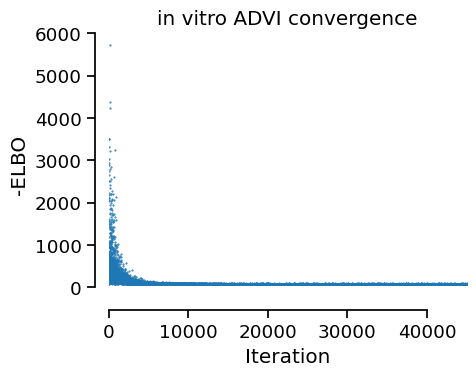

In [ ]:
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(Ex.to_numpy(), name='Ex', b=0.01))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(Ey.to_numpy(), name='Ey', b=0.01))
    e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=en.T)
    chi_obs = xn.T # pm.Normal('chi_obs', mu=0, sigma=10, observed=xn.T)
    y_obs = yn.T # pm.Normal('y_obs', mu=0, sigma=10, observed=yn.T)
    likelihood = pm.Deterministic('vn', (e_obs * (np.ones(en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))[2])
    v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=vn.squeeze().T)

    N_ITERATIONS = 45000

with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = advi.fit(
        n= N_ITERATIONS, 
        callbacks = [tracker],
        obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
        total_grad_norm_constraint=0.7,
        obj_n_mc=1)

with sns.plotting_context('notebook', font_scale=1.2):

    fig = plt.figure(figsize=(5,4))
    plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
    # plt.ylim([-1E1, 1E3])
    plt.xlim([0, N_ITERATIONS])
    sns.despine(trim=True, offset=10)

    plt.ylabel('-ELBO')
    plt.xlabel('Iteration')
    plt.title('in vitro ADVI convergence')
    plt.tight_layout()

with pymc_model:
    trace = approx.sample(1000)
    ppc_vi = pm.sample_posterior_predictive(trace)

# 2 min

In [103]:
with gzip.open("../../data/results/tracePickles/wu2004_validation.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace":trace,
                "ppc":ppc_vi
                },
                f,
            )

## Analysis

In [14]:
picklefolder = '../../data/results/tracePickles/'
with gzip.open(picklefolder + 'wu2004_validation.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')
trace=traces['trace']
ppc_vi=traces['ppc']

In [15]:
metabolites = giersch_data[['2PG','PEP']]
metabolites.head(2)

,2PG,PEP
0,170.0,50.0
1,60.0,103.0


In [16]:
def calculate_Smallbone_ss(Ea, Eb):
    """
    As outlined in Smallbone et al. 2007, Equations 6 and 10

    Because compartment volumes usually have a value of 1, I have 
    simply opted to make np.ones matrices instead of calling on 
    roadrunner for the compartment volumes.

    """
    r = te.loada(wu_ant)
    r.conservedMoietyAnalysis = True
    a = r.getIndependentFloatingSpeciesIds()
    b = r.getFloatingSpeciesIds()
    squiggle_idx = [b.index(i) for i in a if i in b]
    squiggle_idx.sort()
    
    t1 = np.linalg.inv(np.diag(x_star))
    t2 = np.linalg.inv(np.diag(np.ones(len(x_star))))
    t3 = N
    t4 = np.linalg.pinv(N[squiggle_idx,:])
    t5 = np.diag(np.ones(len(squiggle_idx)))
    t6 = np.diag(x_star[squiggle_idx])
    L = t1 @ t2 @ t3 @ t4 @ t5 @ t6 # link matrix
    
    L_ = r.getLinkMatrix()

    # solving for equation 10, steady state internal metabolite concentrations
    t7 = N[squiggle_idx,:]
    t7_ = r.getReducedStoichiometryMatrix()
    t8 = np.diag(v_star)
    
    # d = t7_ @ t8 @ Ea @ L
    # print(np.linalg.matrix_rank(d)) 

    t100 = -np.linalg.inv(t7_ @ t8 @ Ea @ L_) 
    t101 = t7_ @ t8 @ Eb @ (yn).T # here, we may need to add in another dimension
    chi_star = t100 @ t101

    # chi_star.rename({1:'met_conc'}, axis=1, inplace=True)
    res = {squiggle_idx[i]: b[i] for i in range(len(squiggle_idx))}
    chi_star = chi_star.rename(index=res)

    return chi_star

In [17]:
chi = calculate_Smallbone_ss(BMCA_obj01.Ex, BMCA_obj01.Ey)

In [18]:
recovered_met_concs = (np.exp(BMCA_obj01.xn))*BMCA_obj01.x_star

Text(0, 0.5, 'x values using Smallbone ss')

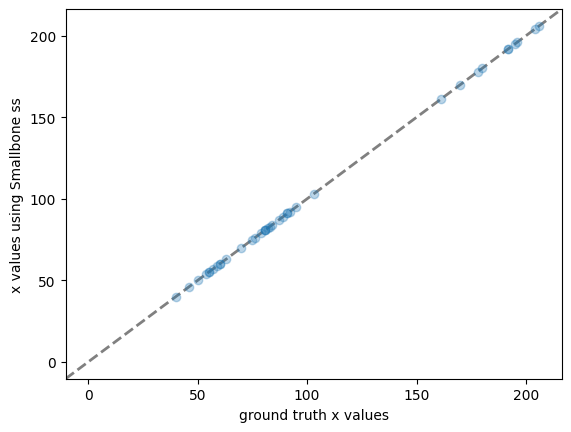

In [18]:
plt.scatter(giersch_data[['2PG','PEP']], 
            recovered_met_concs, alpha=0.3, zorder=100)
plt.axline([0, 0], [10, 10], c='gray', linestyle='dashed', linewidth=2)

plt.title('')
plt.xlabel('ground truth x values')
plt.ylabel('x values using Smallbone ss')

In [19]:
ppc = ppc_vi.posterior_predictive['v_hat_obs']*v_star[0]
median = ppc.median(dim=['chain','draw'])
v_hat_obs_post_df = pd.DataFrame(np.array(median))

hpd = pm.hdi(ppc)
err = np.abs(hpd - median).to_array()[0]

Text(0, 0.5, 'median posterior predictive flux values')

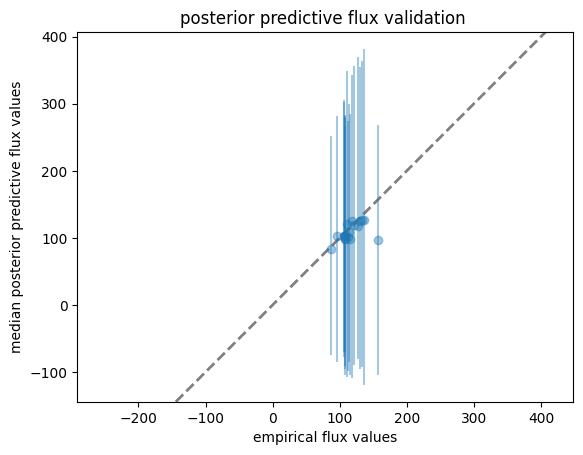

In [20]:
plt.errorbar(BMCA_obj01.vn*v_star[0], median, yerr=err.T, alpha=0.4, fmt='o', label='prior', zorder=100)

plt.axis('equal')
plt.axline([0, 0], [2, 2], c='gray', linestyle='dashed', linewidth=2)

plt.title('posterior predictive flux validation ')
plt.xlabel('empirical flux values')
plt.ylabel('median posterior predictive flux values')

Text(0, 0.5, 'median posterior predictive flux values')

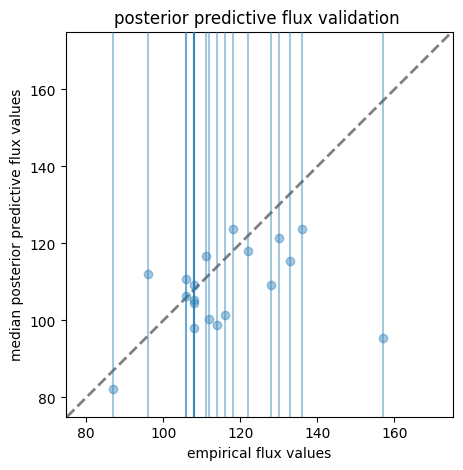

In [24]:
plt.figure(figsize=(5, 5))
plt.errorbar(BMCA_obj01.vn*v_star[0], median, yerr=err.T, alpha=0.4, fmt='o', label='prior', zorder=100)

plt.axis('equal')
plt.axline([0, 0], [2, 2], c='gray', linestyle='dashed', linewidth=2)

plt.ylim(75, 175)
plt.xlim(75, 175)

plt.title('posterior predictive flux validation ')
plt.xlabel('empirical flux values')
plt.ylabel('median posterior predictive flux values')

In [21]:
Ex_advi = util.get_az_summary(trace)
Ey_advi = util.get_az_summary(trace, elasticity='Ey')

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [82]:
mean_elasticities_df = pd.DataFrame(np.concatenate((Ex_advi,Ey_advi)), columns=['predicted'], 
                               index=[i + '_' + ii for i in Ex.index for ii in Ex.columns]+[i + '_' + ii for i in Ey.index for ii in Ey.columns])
mean_elasticities_df 

,predicted
PGM_pg2,-0.817
PGM_pep,0.004
ENO_pg2,0.820
ENO_pep,-0.824
PK_pg2,-0.109
PK_pep,0.113
PGM_bpg,0.814
PGM_adp,-0.005
ENO_bpg,-0.004
ENO_adp,-0.004


In [83]:
mean_elasticities_df.reset_index()

,index,predicted
0,PGM_pg2,-0.817
1,PGM_pep,0.004
2,ENO_pg2,0.820
3,ENO_pep,-0.824
4,PK_pg2,-0.109
5,PK_pep,0.113
6,PGM_bpg,0.814
7,PGM_adp,-0.005
8,ENO_bpg,-0.004
9,ENO_adp,-0.004


In [74]:
trace.posterior['Ex'].to_numpy().shape

(1, 1000, 3, 2)

In [79]:
ex = trace.posterior['Ex'].to_numpy().reshape((1000, -1))
ey = trace.posterior['Ey'].to_numpy().reshape((1000, -1))
e_all = np.hstack([ex, ey])

In [75]:
e_labels = [i + '_' + ii for i in Ex.index for ii in Ex.columns]+[i + '_' + ii for i in Ey.index for ii in Ey.columns]

In [80]:
e_df = pd.DataFrame(e_all, columns=e_labels)

# Create an empty DataFrame to store HDI results in wide format
hdi_results = pd.DataFrame(columns=e_df.columns)

# Iterate through each column and calculate HDI separately
for column in e_df.columns:
    hdi = pm.hdi(e_df[column].values)
    hdi_results[column] = hdi

# Display or use the DataFrame with HDI results in wide format
hdi_results

e_df = hdi_results
e_df

,PGM_pg2,PGM_pep,ENO_pg2,ENO_pep,PK_pg2,PK_pep,PGM_bpg,PGM_adp,ENO_bpg,ENO_adp,PK_bpg,PK_adp
0,-1.805891,-0.022095,-0.182346,-1.815231,-0.153768,-0.003137,-0.171923,-0.033537,-0.035914,-0.032435,-0.024915,0.526820
1,0.144455,0.033815,1.853157,0.186973,-0.059991,0.246788,1.852898,0.022704,0.025270,0.023802,0.032025,0.682765


In [23]:
def run_prior_predictive(BMCA_obj):
    ll = emll.LinLogLeastNorm(N, BMCA_obj.Ex, BMCA_obj.Ey, BMCA_obj.v_star, driver='gelsy')
    
    with pm.Model() as pymc_model:
        # Initialize elasticities
        # Ex and Ey have to be shape (rxns, mets)
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), 'Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), 'Ey'))

        trace_prior = pm.sample_prior_predictive(random_seed=SEED)

    return trace_prior


### Calculating CCCs

In [ ]:
Ex01_prior_med = util.get_az_summary(run_prior_predictive(BMCA_obj01)['prior']['Ex'])
Ex01_prior_med

In [25]:
priorCCC01 = util.estimate_CCCs(BMCA_obj01, Ex01_prior_med.reshape((3,-1)))

In [26]:
postCCC01 = util.estimate_CCCs(BMCA_obj01, Ex_advi.reshape((3,-1)))
postCCC01.shape

(1000, 2, 3)

### Calculating FCCs

In [27]:
priorFCC01 = util.estimate_FCCs(BMCA_obj01, np.squeeze(run_prior_predictive(BMCA_obj01)['prior']['Ex'].values))
priorFCC01.shape

Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]


(500, 3, 3)

In [32]:
postFCC01 = util.estimate_FCCs(BMCA_obj01, np.squeeze(trace.posterior['Ex'].values))
postFCC01.shape

(1000, 3, 3)

### Visualizing FCC predictions

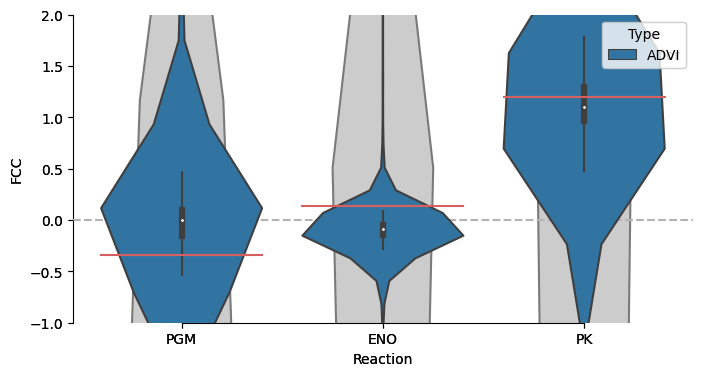

In [104]:
# Create a figure and axes
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax2 = fig.add_subplot(111, frameon=False, sharex=ax, sharey=ax)

# Define palette colors for different types
my_pal = {"Prior": ".8", "ADVI": "tab:blue"}

# Filter data for specific type 'Prior'
# Reshape to long-form DataFrame
data_prior = pd.DataFrame(priorFCC01[:,2,:], columns=['PGM', 'ENO', 'PK'])
data_prior = data_prior.melt(var_name='Reaction', value_name='FCC')
data_prior['Type'] = 'Prior'  # adds same label to all rows

# Create violin plot for 'Prior' type on ax
sns.violinplot(
    x='Reaction', y='FCC', hue='Type', data=data_prior,
    density_norm='width', width=0.5, palette=my_pal, saturation=1., alpha=0.1, ax=ax
)

data_post = pd.DataFrame(postFCC01[:,2,:], columns=['PGM', 'ENO', 'PK'])
data_post = data_post.melt(var_name='Reaction', value_name='FCC')
data_post['Type'] = 'ADVI'  # adds same label to all rows
sns.violinplot(
    x='Reaction', y='FCC', hue='Type', data=data_post,
    density_norm='width', width=0.8,
    hue_order=['ADVI'],
    palette=my_pal, ax=ax2
)

# Control coefficients estimated from elasticities; Wu table 7
wu_ccs = np.array([-0.34 , 0.14 , 1.20])
# Additional plot elements or customizations
for i, cc in enumerate(wu_ccs):
    ax2.plot([i - .4, i + .4], [cc, cc], '-', color=sns.color_palette('muted')[3])


# Set y-axis limit for ax
ax.set_ylim([-1, 2])
# Add horizontal line at y=0 to ax
ax.axhline(0, ls='--', color='.7', zorder=10000)
# Remove spines for aesthetics
sns.despine(trim=True)

In [ ]:
man = util.estimate_FCCs(BMCA_obj01, util.get_az_summary(trace).reshape((3,-1)))
man